### Load Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [3]:
print(tf.__version__)

2.15.0


### Load Dataset

In [4]:
data_path = "mems_vehicle_surroundings_perception_data.npz"

In [5]:
data = np.load(data_path, allow_pickle=True)

In [6]:
# Get signals & labels
signals = data["signals"]
labels = data["labels"]

In [7]:
# Shape: batch x time x channel
print(signals.shape)

(823, 1600, 27)


In [8]:
# Get cross-validation splits used in the paper
cv_splits = data["cv_splits"]

In [9]:
n_splits = len(cv_splits)
print(n_splits)

5


In [10]:
# Get class names
class_names = data["class_names"]
print(class_names)

['Close engine bonnet' 'Close car door' 'Close fuel cap' 'Close trunk'
 'Knock on window' 'Lift car' 'Lock engine bonnet' 'Other' 'Open car door'
 'Open fuel cap' 'Open trunk' 'Collision w/ car' 'Rain' 'Loosen wheel nut'
 'Scratch car door' 'Collision w/ shopping cart' 'Unlock engine bonnet']


In [11]:
n_classes = len(class_names)

In [12]:
# Get channel names
channel_names = data["channel_names"]
print(channel_names)

['roof_bma400_accel_x' 'roof_bma400_accel_y' 'roof_bma400_accel_z'
 'roof_bmi270_accel_x' 'roof_bmi270_accel_y' 'roof_bmi270_accel_z'
 'roof_bmi270_gyro_x' 'roof_bmi270_gyro_y' 'roof_bmi270_gyro_z'
 'door_bma400_accel_x' 'door_bma400_accel_y' 'door_bma400_accel_z'
 'door_bmi270_accel_x' 'door_bmi270_accel_y' 'door_bmi270_accel_z'
 'door_bmi270_gyro_x' 'door_bmi270_gyro_y' 'door_bmi270_gyro_z'
 'rear_bma400_accel_x' 'rear_bma400_accel_y' 'rear_bma400_accel_z'
 'rear_bmi270_accel_x' 'rear_bmi270_accel_y' 'rear_bmi270_accel_z'
 'rear_bmi270_gyro_x' 'rear_bmi270_gyro_y' 'rear_bmi270_gyro_z']


In [13]:
# Downsample signals from 400 Hz to 100 Hz using 2 FIR filters
x_data = scipy.signal.decimate(signals, 2, 5, 'fir', axis=1, zero_phase=False)
x_data = scipy.signal.decimate(x_data, 2, 5, 'fir', axis=1, zero_phase=False)

In [14]:
# Sample signal
idx = 120

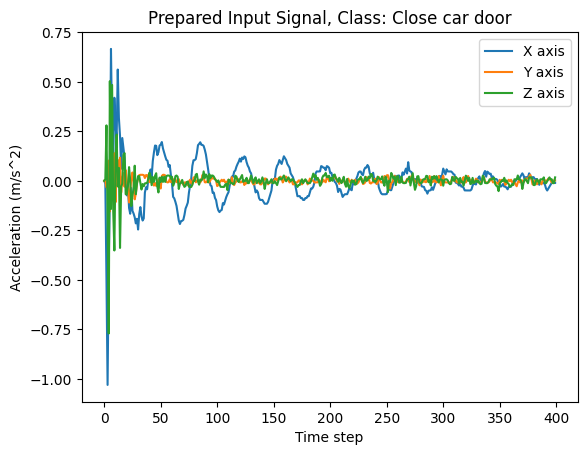

In [15]:
plt.plot(x_data[idx, :, :3])
plt.title(f"Prepared Input Signal, Class: {class_names[labels[idx]]}")
plt.xlabel("Time step")
plt.ylabel("Acceleration (m/s^2)")
plt.legend(["X axis", "Y axis", "Z axis"])
plt.show()

In [16]:
# Convert labels to categorical
y_data = keras.utils.to_categorical(labels, num_classes=n_classes)

In [17]:
# Prepared dataset
# Shape: batch x time x channel
print(x_data.shape)
print(y_data.shape)

(823, 400, 27)
(823, 17)


In [18]:
n_time = x_data.shape[1]
n_channels = x_data.shape[2]

### Train CNN

In [19]:
# Training parameters
epochs = 100
batch_size = 32
lr = 1e-3

# Number of repetitions
n_reps = 20

In [20]:
def create_model():
    # Model parameters
    input_shape = (n_time, n_channels)
    kernel_size = 5
    pool_size = 3

    # Create layers
    model = keras.Sequential()
    model.add(keras.Input(input_shape))
    model.add(layers.Conv1D(12, kernel_size, activation="relu"))
    model.add(layers.MaxPool1D(pool_size))
    model.add(layers.Conv1D(24, kernel_size, activation="relu"))
    model.add(layers.MaxPool1D(pool_size))
    model.add(layers.Conv1D(48, kernel_size, activation="relu"))
    model.add(layers.MaxPool1D(pool_size))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_classes, activation="softmax"))

    # Compile model
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=["accuracy"])
    
    return model

In [ ]:
# Repeat training multiple times to account for random initialization

accuracies = np.zeros((n_reps, n_splits)) # model accuracies

for rep in range(n_reps):
    for split in range(n_splits):
        # Create model
        model = create_model()

        # Get CV split
        train_idx = cv_splits[split][0]
        test_idx = cv_splits[split][1]
        x_train, y_train = x_data[train_idx], y_data[train_idx]
        x_test, y_test = x_data[test_idx], y_data[test_idx]

        # Train model
        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Evaluate model
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        accuracies[rep, split] = accuracy

    avg_accuracy = np.mean(accuracies[rep])
    print(f"Rep: {rep+1}/{n_reps}, CV-Accuracy: {avg_accuracy*100:.1f} %")

In [22]:
np.mean(accuracies)

0.8902712488174438

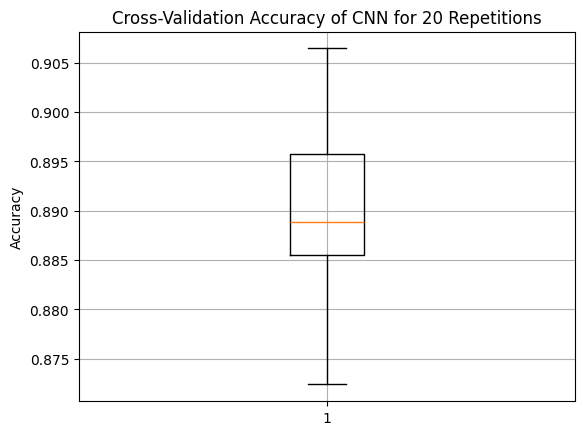

In [23]:
plt.boxplot(np.mean(accuracies, axis=1))
plt.grid()
plt.ylabel("Accuracy")
plt.title(f"Cross-Validation Accuracy of CNN for {n_reps} Repetitions")
plt.savefig("results.png", dpi=300, bbox_inches="tight")
plt.show()